In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp

import bayesflow as bf
from bayesflow.amortizers import AmortizedPointEstimator
from bayesflow.benchmarks import Benchmark
from bayesflow.helper_networks import ConfigurableMLP
from bayesflow.simulation import GenerativeModel, Prior, Simulator
from bayesflow.summary_networks import DeepSet

np.random.seed(2024)


/opt/anaconda3/envs/bayesflow/lib/python3.11/site-packages/bayesflow/trainers.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


bayesflow, in the framework of MLP networks, has an unavoidable coupling problem, that is, it cannot distinguish the effects of miu and sigma on the data, so it tends to get the "mean" of the two. Modifying the neural network architecture in the inference network, such as making it multi-headed, can help a little. It would be helpful to modify the loss function to highlight the difference between sigma and mu, but there are too many verification elements in the loss function

In [2]:

def batch_prior_fun(batch_size):
    #  N(mean, stddev)
    mean, stddev = 0.0, 1.0
    miu_dist = tfp.distributions.Normal(loc=mean, scale=stddev)
    miu_samples = miu_dist.sample((batch_size, 1))   
    #InverseGamma(alpha, beta)
    alpha, beta = 2.0, 1.0 
    sigma2_dist = tfp.distributions.InverseGamma(concentration=alpha, scale=beta)
    sigma2_samples = sigma2_dist.sample((batch_size, 1))

    return miu_samples,sigma2_samples

def batch_simulator_fun(miu_sigma2, n_obs=1000):
    miu = miu_sigma2[0]
    sigma2 = miu_sigma2[1]
    # Y ~ N(miu, sqrt(sigma^2))
    return tf.random.normal(
        (miu.shape[0], n_obs), mean=miu, stddev=tf.sqrt(sigma2)
    )[:, :, None]


In [3]:
from bayesflow.amortizers import AmortizedPointEstimator
from bayesflow.helper_networks import ConfigurableMLP

prior = Prior(batch_prior_fun=batch_prior_fun)
simulator = Simulator(batch_simulator_fun=batch_simulator_fun)
generative_model = GenerativeModel(prior=prior, simulator=simulator)

# define inference
summary_dim = 10
summary_net = DeepSet(summary_dim)

inference_net = ConfigurableMLP(input_dim=summary_dim, output_dim=2, dropout_rate=0.1)

amortizer = AmortizedPointEstimator(inference_net, summary_net=summary_net, norm_ord=1)


INFO:root:Performing 2 pilot runs with the anonymous model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 2, 1)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 1000, 1)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


In [4]:
# Default configuration
def config(forward_dict):
    """Helper function for posterior configuration."""
    input_dict = {}
    input_dict["parameters"] = forward_dict["prior_draws"]
    input_dict["summary_conditions"] = forward_dict["sim_data"]
    return input_dict


#Trainer
from bayesflow.trainers import Trainer
trainer = Trainer(
    amortizer=amortizer,
    configurator=config,
    generative_model=generative_model
)

h = trainer.train_online(1, 500, batch_size=32)


INFO:root:Performing a consistency check with provided components...
INFO:root:Done.
Training epoch 1: 100%|██████████| 500/500 [00:25<00:00, 19.85it/s, Epoch: 1, Iter: 500,Loss: 1.283,Avg.Loss: 1.320,LR: 4.93E-09]


In [5]:
num_test = 1000

# get real parameter
test_param_fun = lambda batch_size: (tf.ones((batch_size, 1)) * 0,  # miu = 0
                                     tf.ones((batch_size, 1)) * 1.0)  # sigma^2 = 1.0

# get test data
test_model = GenerativeModel(prior=Prior(batch_prior_fun=test_param_fun), simulator=simulator)
test_data = config(test_model(num_test))


INFO:root:Performing 2 pilot runs with the anonymous model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 2, 1)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 1000, 1)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


In [6]:
estimated_values = amortizer.estimate(test_data)

In [7]:
#Separate two parameters
estimated_miu = estimated_values[:, 0]
estimated_sigma = estimated_values[:, 1]

In [8]:
def bayes_estimator_mu(Z, mu_0=0, kappa_0=1, alpha_0=2, beta_0=1):
    """
    Bayesian estimator: Calculates the posterior parameters of a Normal-Inverse-Gamma distribution 
    based on observed data, and samples mu and sigma separately.
    
    Parameters:
    - Z: Input data, shape TensorShape([n, 1]).
    - mu_0: Prior mean.
    - kappa_0: Prior sample size.
    - alpha_0: Initial shape parameter of the Inverse-Gamma distribution.
    - beta_0: Initial scale parameter of the Inverse-Gamma distribution.
    
    Returns:
    - posterior_samples_mu: Samples of the mean (mu) from the posterior distribution.
    - posterior_samples_sigma: Samples of the standard deviation (sigma) from the posterior distribution.
    """
    # Ensure Z is a TensorFlow tensor
    Z = tf.convert_to_tensor(Z, dtype=tf.float32)

    # Compute statistics from the observed data
    n = tf.cast(Z.shape[0], tf.float32)  # Number of samples
    z_bar = tf.reduce_mean(Z)  # Sample mean
    S = tf.reduce_sum(tf.square(Z - z_bar))  # Sum of squared differences

    # Update posterior parameters
    kappa_n = kappa_0 + n
    mu_n = (kappa_0 * mu_0 + n * z_bar) / kappa_n
    alpha_n = alpha_0 + n / 2
    beta_n = beta_0 + S / 2 + (kappa_0 * n * tf.square(z_bar - mu_0)) / (2 * kappa_n)

    # Sample sigma^2 from the posterior Inverse-Gamma distribution
    dist_sigma2 = tfp.distributions.InverseGamma(concentration=alpha_n, scale=beta_n)
    posterior_samples_sigma2 = dist_sigma2.sample(1000).numpy()

    # Compute sigma and sample from the posterior distribution
    posterior_samples_sigma = np.sqrt(posterior_samples_sigma2)

    # Sample mu from the posterior Normal distribution
    dist_mu = tfp.distributions.Normal(loc=mu_n, scale=tf.sqrt(1 / (kappa_0 + n)))
    posterior_samples_mu = dist_mu.sample(1000).numpy()

    return posterior_samples_mu

reference = bayes_estimator_mu(test_data["summary_conditions"])


/var/folders/xh/6yy1qtv504b1yv27rltr5cdc0000gn/T/ipykernel_6216/3793600733.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(prior_samples, label="Prior for Miu", shade=True)


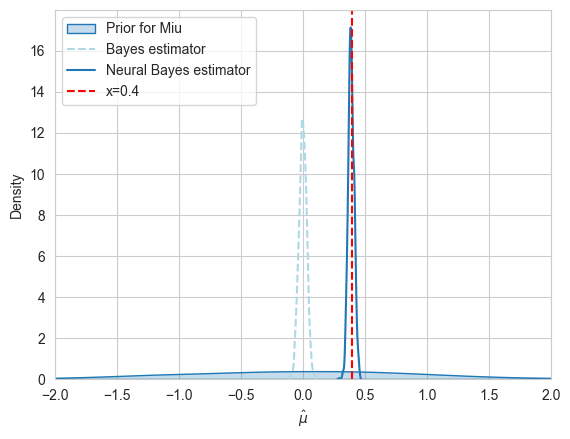

In [9]:
# define the prior dis
prior_dist = tfp.distributions.Normal(0.0, 1.0)
prior_samples = prior_dist.sample(1000).numpy()

# plot
sns.kdeplot(prior_samples, label="Prior for Miu", shade=True)
sns.kdeplot(reference, label="Bayes estimator", color="lightblue", linestyle="--")
sns.kdeplot(estimated_miu, label="Neural Bayes estimator")
plt.axvline(x=0.4, color="red", linestyle="--", linewidth=1.5, label="x=0.4")

plt.xlim(-2, 2)

plt.xlabel(r"$\hat\mu$")

_ = plt.legend()

In [10]:
def bayes_estimator_sigma(Z, mu_0=0, kappa_0=1, alpha_0=2, beta_0=1):
    """
    Bayesian estimator: Calculates the posterior parameters of a Normal-Inverse-Gamma distribution 
    based on observed data, and samples sigma from the posterior distribution.
    
    Parameters:
    - Z: Input data, shape TensorShape([n, 1]).
    - mu_0: Prior mean.
    - kappa_0: Prior sample size.
    - alpha_0: Initial shape parameter of the Inverse-Gamma distribution.
    - beta_0: Initial scale parameter of the Inverse-Gamma distribution.
    
    Returns:
    - posterior_samples_sigma: Samples of the standard deviation (sigma) from the posterior distribution.
    """
    # Ensure Z is a TensorFlow tensor
    Z = tf.convert_to_tensor(Z, dtype=tf.float32)

    # Compute statistics from the observed data
    n = tf.cast(Z.shape[0], tf.float32)  # Number of samples
    z_bar = tf.reduce_mean(Z)  # Sample mean
    S = tf.reduce_sum(tf.square(Z - z_bar))  # Sum of squared differences

    # Update posterior parameters
    kappa_n = kappa_0 + n
    mu_n = (kappa_0 * mu_0 + n * z_bar) / kappa_n
    alpha_n = alpha_0 + n / 2
    beta_n = beta_0 + S / 2 + (kappa_0 * n * tf.square(z_bar - mu_0)) / (2 * kappa_n)

    # Sample sigma^2 from the posterior Inverse-Gamma distribution
    dist_sigma2 = tfp.distributions.InverseGamma(concentration=alpha_n, scale=beta_n)
    posterior_samples_sigma2 = dist_sigma2.sample(1000).numpy()

    # Compute sigma and sample from the posterior distribution
    posterior_samples_sigma = np.sqrt(posterior_samples_sigma2)

    return posterior_samples_sigma

# Reshape the data
# summary_conditions = tf.reshape(test_data["summary_conditions"], [-1, 1])
summary_conditions = tf.reshape(test_data["summary_conditions"][:, 0, :], [-1, 1])

# Call bayes_estimator
reference = bayes_estimator_sigma(summary_conditions)


/var/folders/xh/6yy1qtv504b1yv27rltr5cdc0000gn/T/ipykernel_6216/3098350864.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(prior_samples, label="Prior for Sigma", shade=True)


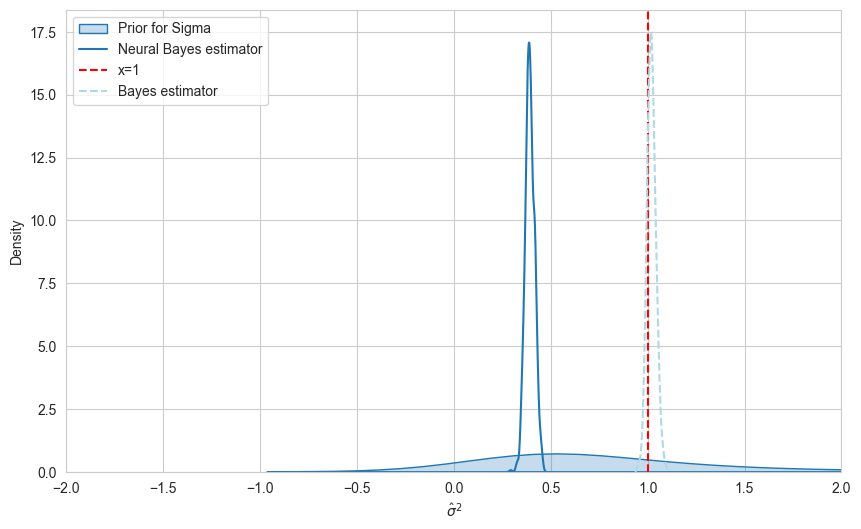

In [11]:
# Define the prior distribution for sigma as an Inverse Gamma distribution
prior_dist = tfp.distributions.InverseGamma(2.0, 1.0)

# Sample 1000 points from the distribution
prior_samples = prior_dist.sample(1000).numpy()

# Create the plot
plt.figure(figsize=(10, 6))
sns.kdeplot(prior_samples, label="Prior for Sigma", shade=True)
sns.kdeplot(estimated_sigma, label="Neural Bayes estimator")
plt.axvline(x=1, color="red", linestyle="--", linewidth=1.5, label="x=1")
sns.kdeplot(reference, label="Bayes estimator", color="lightblue", linestyle="--")

# Set x-axis limits
plt.xlim(-2, 2)

# Add labels and legend
plt.xlabel(r"$\hat\sigma^2$")
_ = plt.legend()

# Display the plot
plt.show()
